In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
INPUT_DATA_FILE_PATH = '../../data/gifts.csv'

SLEIGH_BASE_WEIGHT = 10
SLEIGH_MAX_WEIGHT = 1000    # excluding the sleigh's base weight

In [3]:
input_data = pd.read_csv(INPUT_DATA_FILE_PATH)

input_data.head()

,GiftId,Latitude,Longitude,Weight
0,1,16.345769,6.303545,1.000000
1,2,12.494749,28.626396,15.524480
2,3,27.794615,60.032495,8.058499
3,4,44.426992,110.114216,1.000000
4,5,-69.854088,87.946878,25.088892


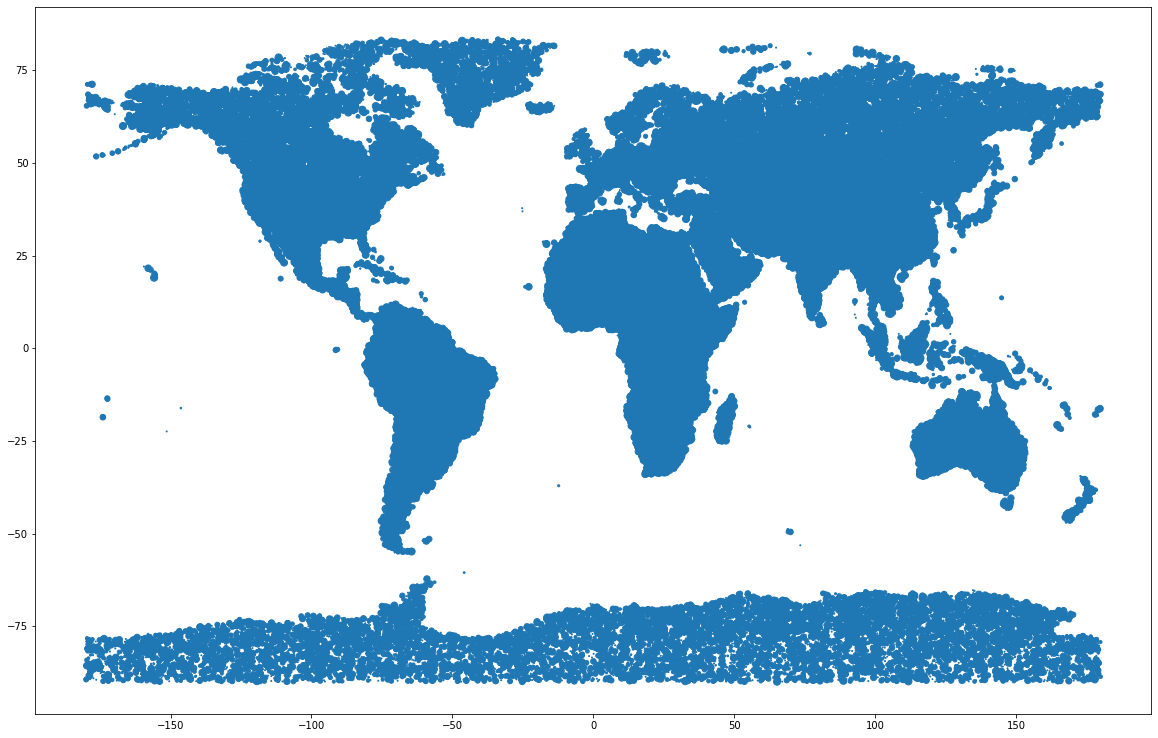

In [4]:
plt.rcParams['figure.figsize'] = (20, 13)
plt.scatter(input_data.Longitude, input_data.Latitude, s=input_data.Weight)

In [5]:
NORTH_POLE_COORDINATES = {'Latitude': 90, 'Longitude': 0}

In [6]:
def haversine_np(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [7]:
df = input_data.assign(Km_from_north_pole=lambda x: haversine_np((x.Latitude, x.Longitude), (NORTH_POLE_COORDINATES['Latitude'], NORTH_POLE_COORDINATES['Longitude'])))

df.head()

,GiftId,Latitude,Longitude,Weight,Km_from_north_pole
0,1,16.345769,6.303545,1.000000,8184.834792
1,2,12.494749,28.626396,15.524480,8612.779778
2,3,27.794615,60.032495,8.058499,6912.580452
3,4,44.426992,110.114216,1.000000,5064.305643
4,5,-69.854088,87.946878,25.088892,17763.803714


In [8]:
def bearing_np(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = np.cos(lat2) * np.sin(dlon)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

    return np.arctan2(x, y)

In [9]:
df = df.assign(Bearing_to_north_pole=lambda x: bearing_np((NORTH_POLE_COORDINATES['Latitude'], NORTH_POLE_COORDINATES['Longitude']), (x.Latitude, x.Longitude)))

df.head()

,GiftId,Latitude,Longitude,Weight,Km_from_north_pole,Bearing_to_north_pole
0,1,16.345769,6.303545,1.000000,8184.834792,3.031575
1,2,12.494749,28.626396,15.524480,8612.779778,2.641968
2,3,27.794615,60.032495,8.058499,6912.580452,2.093828
3,4,44.426992,110.114216,1.000000,5064.305643,1.219737
4,5,-69.854088,87.946878,25.088892,17763.803714,1.606630


In [10]:
def equirectangular_dist_approx_np(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    x = (lon2 - lon1) * np.cos((lat1 + lat2) / 2)
    y = lat2 - lat1
    return np.sqrt(x * x + y * y) * 6371
    

In [11]:
df = df.assign(Approx_dist_to_northpole=lambda x: equirectangular_dist_approx_np((NORTH_POLE_COORDINATES['Latitude'], NORTH_POLE_COORDINATES['Longitude']), (x.Latitude, x.Longitude)))

df.head()

,GiftId,Latitude,Longitude,Weight,Km_from_north_pole,Bearing_to_north_pole,Approx_dist_to_northpole
0,1,16.345769,6.303545,1.000000,8184.834792,3.031575,8200.745909
1,2,12.494749,28.626396,15.524480,8612.779778,2.641968,8845.521724
2,3,27.794615,60.032495,8.058499,6912.580452,2.093828,7728.810869
3,4,44.426992,110.114216,1.000000,5064.305643,1.219737,6940.265878
4,5,-69.854088,87.946878,25.088892,17763.803714,1.606630,20215.278750


In [12]:
def reindeer_weariness(points: pd.DataFrame):
    result = 0

    previous_point = (NORTH_POLE_COORDINATES['Latitude'], NORTH_POLE_COORDINATES['Longitude'])
    
    current_total_weight = points['Weight'].sum() + SLEIGH_BASE_WEIGHT

    for _, point in points.iterrows():
        current_point = (point['Latitude'], point['Longitude'])
        distance = haversine_np(previous_point, current_point)
        result += distance * current_total_weight
        previous_point = current_point
        current_total_weight -= point.Weight
    
    return result


## Nearest Neighbor Approach

In [13]:
def nearest_neighbor(points: pd.DataFrame) -> pd.DataFrame:
    S = pd.DataFrame()
    R = points.copy()
    trip_id = 0

    while not R.empty:
        R = R.sort_values(by=['Km_from_north_pole'], ascending=False)
        current_point = R.iloc[0]
        L = pd.DataFrame([{'TripId': trip_id, 'GiftId': current_point['GiftId'], 'Latitude': current_point['Latitude'], 'Longitude': current_point['Longitude'], 'Weight': current_point['Weight'], 'Km_from_north_pole': current_point['Km_from_north_pole']}])
        R = R[1:]
        current_weight = SLEIGH_BASE_WEIGHT + current_point['Weight']
        R = R.assign(Bearing_to_last_stop=lambda x: bearing_np((current_point['Latitude'], current_point['Longitude']), (x.Latitude, x.Longitude))).sort_values(by=['Bearing_to_last_stop']).reset_index(drop=True)
        index = -1
        while current_weight < SLEIGH_MAX_WEIGHT and not R.empty and len(R) > index + 1:
            index += 1
            current_point = R.iloc[index]
            if current_weight + current_point.Weight < SLEIGH_MAX_WEIGHT:
                L = L.append({'TripId': trip_id, 'GiftId': current_point['GiftId'], 'Latitude': current_point['Latitude'], 'Longitude': current_point['Longitude'], 'Weight': current_point['Weight'], 'Km_from_north_pole': current_point['Km_from_north_pole']}, ignore_index=True)
                R = R.drop(index=index, axis=0).reset_index(drop=True)
                index -= 1
                current_weight += current_point['Weight']
            if R.empty:
                break
        L = L.sort_values(by=['Km_from_north_pole']).drop(['Weight', 'Longitude', 'Latitude', 'Km_from_north_pole'], axis=1)
        S = S.append(L)
        trip_id += 1
    
    return pd.DataFrame(S)


In [14]:
test = nearest_neighbor(df[:10])

test.head()

test.to_csv('test.csv', index=False)

print(reindeer_weariness(test))

MAX_NUMBER_OF_STOPS = 10

wearinesses = []

for number_of_stops in range(MAX_NUMBER_OF_STOPS):
    route = nearest_neighbor(df, number_of_stops)
    weariness = reindeer_weariness(route)
    wearinesses.append({'Number_of_stops': number_of_stops, 'Weariness': weariness})


wearinesses = pd.DataFrame(wearinesses)

plot = wearinesses.Weariness.plot()
plot.set_ylabel('Reindeer Weariness')
plot.set_xlabel('Max number of stops')

In [15]:
solution = nearest_neighbor(df)

solution.to_csv('bearing.csv', index=False)